### 1.1) Implementación del algoritmo K-means sin bibliotecas

Importación de la librerías necesarias para mostrar los resultados del análisis.

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from numpy.random import uniform
from sklearn.datasets import make_blobs
import seaborn as sns
import random
import pandas as pd

Definición de la clase que implementa KMeans. Además también se crea un método que define la función euclidea.

[ 6.72465737e+00  4.93571829e+00 -6.95672890e+00  4.14445643e+00
 -6.35768563e+00  5.93040859e+00 -6.86662530e+00 -2.30033403e+00
 -8.25729656e+00  1.22977950e+00 -2.14756160e+00  6.63033968e+00
  4.15533361e+00  7.27297263e+00 -6.66553345e+00  7.33899681e+00
 -3.98771961e+00  2.13581758e+00 -2.26723535e+00  4.33695880e+00
  2.22135993e+00 -2.21307735e+00  8.22003828e-01 -7.10308998e+00
  1.30699653e+00 -3.21125072e+00 -6.08859524e+00 -3.31769123e+00
  5.88972015e+00 -6.65216726e+00 -2.72886951e+00 -7.55965191e+00
  6.74584878e+00 -6.91433896e+00 -5.01385268e+00  6.76914845e+00
  8.09999642e+00 -2.25164723e+00 -7.12501531e+00  2.30329210e+00
 -1.77073104e+00 -7.72642091e+00  5.82663242e+00 -7.94193090e+00
 -2.54502366e+00  5.82335562e+00 -3.18611962e+00 -6.52183983e+00
  1.19330522e+00 -6.25395984e+00 -2.98837186e+00 -3.52202874e+00
 -2.52269485e+00  5.80913097e+00  7.16819933e+00 -2.67048333e+00
 -3.03895783e+00  3.78775448e+00  3.28921138e+00  6.17781451e+00
  2.06787207e+00 -2.16557

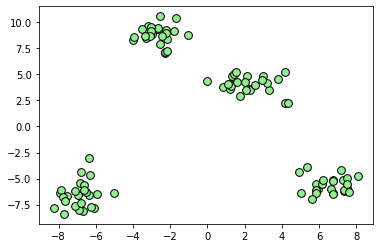

          1         2          3         4  Cluster
0  6.724657 -6.430379  -5.388381 -6.478967        1
1  4.935718 -4.399345  -6.478041 -5.094093        1
2 -6.956729 -6.538958  -8.561637  8.150706        2
3  4.144456  5.193917 -11.107680  8.913963        2
4 -6.357686 -6.583125  -8.587835  7.669971        2


In [25]:
def euclidean(point, data):
    """
    Euclidean distance between point & data.
    Point has dimensions (m,), data has dimensions (n,m), and output will be of size (n,).
    """
    return np.sqrt(np.sum((point - data)**2, axis=1))
class KMeans:
    def __init__(self, n_clusters=8, max_iter=300):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
    def fit(self, X_train):
        # Initialize the centroids, using the "k-means++" method, where a random datapoint is selected as the first,
        # then the rest are initialized w/ probabilities proportional to their distances to the first
        # Pick a random point from train data for first centroid
        self.centroids = [random.choice(X_train)]
        for _ in range(self.n_clusters-1):
            # Calculate distances from points to the centroids
            dists = np.sum([euclidean(centroid, X_train) for centroid in self.centroids], axis=0)
            # Normalize the distances
            dists /= np.sum(dists)
            # Choose remaining points based on their distances
            new_centroid_idx, = np.random.choice(range(len(X_train)), size=1, p=dists)
            self.centroids += [X_train[new_centroid_idx]]
        # This initial method of randomly selecting centroid starts is less effective
        # min_, max_ = np.min(X_train, axis=0), np.max(X_train, axis=0)
        # self.centroids = [uniform(min_, max_) for _ in range(self.n_clusters)]
        # Iterate, adjusting centroids until converged or until passed max_iter
        iteration = 0
        prev_centroids = None
        while np.not_equal(self.centroids, prev_centroids).any() and iteration < self.max_iter:
            # Sort each datapoint, assigning to nearest centroid
            sorted_points = [[] for _ in range(self.n_clusters)]
            for x in X_train:
                dists = euclidean(x, self.centroids)
                centroid_idx = np.argmin(dists)
                sorted_points[centroid_idx].append(x)
            # Push current centroids to previous, reassign centroids as mean of the points belonging to them
            prev_centroids = self.centroids
            self.centroids = [np.mean(cluster, axis=0) for cluster in sorted_points]
            for i, centroid in enumerate(self.centroids):
                if np.isnan(centroid).any():  # Catch any np.nans, resulting from a centroid having no points
                    self.centroids[i] = prev_centroids[i]
            iteration += 1
    def evaluate(self, X):
        centroids = []
        centroid_idxs = []
        for x in X:
            dists = euclidean(x, self.centroids)
            centroid_idx = np.argmin(dists)
            centroids.append(self.centroids[centroid_idx])
            centroid_idxs.append(centroid_idx)
        return centroids, centroid_idxs
# Create a dataset of 2D distributions
centers = 4
X_train, true_labels = make_blobs(n_samples=100, centers=centers, random_state=42, n_features=4)
# Se grafican los datos
plt.scatter(
   X_train[:, 0], X_train[:, 1],
   c='lightgreen', marker='o',
   edgecolor='black', s = 60
)
plt.show()
# Fit centroids to dataset
kmeans = KMeans(n_clusters=centers)
kmeans.fit(X_train)
df = pd.DataFrame(X_train, columns=['1', '2', '3', '4'])

df['Cluster'] = kmeans.evaluate(X_train)[1]
print(df.head())


### 1.2) Implementación de DBSCAN sin bibliotecas

In [26]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random

Create the inicial data

Text(0, 0.5, 'Y')

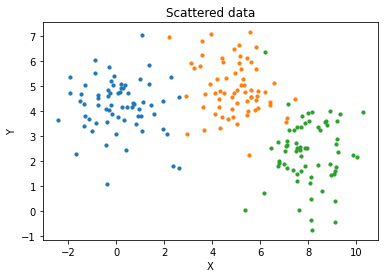

In [39]:
centers = [(0, 4, 2), (5, 5, 3) , (8,2, 1)]
cluster_std = [1.2, 1, 1.1]

X, y= make_blobs(n_samples=200, cluster_std=cluster_std, centers=centers, n_features=3, random_state=1)

plt.scatter(X[y == 0, 0], X[y == 0, 1], s=10, label="Cluster1")
plt.scatter(X[y == 1, 0], X[y == 1, 1], s=10, label="Cluster2")
plt.scatter(X[y == 2, 0], X[y == 2, 1], s=10, label="Cluster3")
plt.title("Scattered data")
plt.xlabel('X')
plt.ylabel('Y')

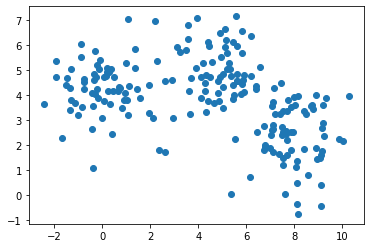

In [42]:
plt.scatter(X[:,0],X[:,1])

In [29]:
def check_core_point(eps,minPts, df, index):
    #get points from given index
    x, y = df.iloc[index]['X']  ,  df.iloc[index]['Y']
    
    #check available points within radius
    temp =  df[((np.abs(x - df['X']) <= eps) & (np.abs(y - df['Y']) <= eps)) & (df.index != index)]
    
    #check how many points are present within radius
    if len(temp) >= minPts:
        #return format (dataframe, is_core, is_border, is_noise)
        return (temp.index , True, False, False)
    
    elif (len(temp) < minPts) and len(temp) > 0:
        #return format (dataframe, is_core, is_border, is_noise)
        return (temp.index , False, True, False)
    
    elif len(temp) == 0:
        #return format (dataframe, is_core, is_border, is_noise)
        return (temp.index , False, False, True)

In [30]:
def cluster_with_stack(eps, minPts, df):
    
    #initiating cluster number
    C = 1
    #initiating stacks to maintain
    current_stack = set()
    unvisited = list(df.index)
    clusters = []
    
    
    while (len(unvisited) != 0): #run until all points have been visited

        #identifier for first point of a cluster
        first_point = True
        
        #choose a random unvisited point
        current_stack.add(random.choice(unvisited))
        
        while len(current_stack) != 0: #run until a cluster is complete
            
            #pop current point from stack
            curr_idx = current_stack.pop()
            
            #check if point is core, neighbour or border
            neigh_indexes, iscore, isborder, isnoise = check_core_point(eps, minPts, df, curr_idx)
            
            #dealing with an edge case
            if (isborder & first_point):
                #for first border point, we label it aand its neighbours as noise 
                clusters.append((curr_idx, 0))
                clusters.extend(list(zip(neigh_indexes,[0 for _ in range(len(neigh_indexes))])))
                
                #label as visited
                unvisited.remove(curr_idx)
                unvisited = [e for e in unvisited if e not in neigh_indexes]
    
                continue
                
            unvisited.remove(curr_idx) #remove point from unvisited list
            
            
            neigh_indexes = set(neigh_indexes) & set(unvisited) #look at only unvisited points
            
            if iscore: #if current point is a core
                first_point = False
                
                clusters.append((curr_idx,C)) #assign to a cluster
                current_stack.update(neigh_indexes) #add neighbours to a stack

            elif isborder: #if current point is a border point
                clusters.append((curr_idx,C))
                
                continue

            elif isnoise: #if current point is noise
                clusters.append((curr_idx, 0))
                
                continue
                
        if not first_point:
            #increment cluster number
            C+=1
        
    return clusters

In [43]:
#radius of the circle defined as 0.6
eps = 0.6
#minimum neighbouring points set to 3
minPts = 3

In [64]:
data = pd.DataFrame(X, columns = ["X", "Y", "Z"] )
print(data.head())
print("len data", len(data))
clustered = cluster_with_stack(eps, minPts, data)
print(data.head())
print("len clustered", len(clustered))
new_clustered = []
for i in range(len(clustered)):
    for cluster in clustered:
        if (i == cluster[0]):
            new_clustered.append(cluster[1])
            break



          X         Y         Z
0  4.334245  3.325804  3.825030
1  7.095286  2.793882  0.312124
2 -1.287562  5.038489 -0.761846
3  2.285590  5.333268  2.790860
4  7.880769  2.495171  2.941869
len data 200
          X         Y         Z
0  4.334245  3.325804  3.825030
1  7.095286  2.793882  0.312124
2 -1.287562  5.038489 -0.761846
3  2.285590  5.333268  2.790860
4  7.880769  2.495171  2.941869
len clustered 201


In [67]:
idx , cluster = list(zip(*clustered))

cluster_df = pd.DataFrame(clustered, columns = ["idx", "cluster"])
print(cluster_df.head(100))

    idx  cluster
0    37        1
1   168        1
2    41        1
3   181        1
4   184        1
..  ...      ...
95   76        2
96   16        2
97   18        2
98   21        2
99  151        2

[100 rows x 2 columns]


Text(0, 0.5, 'Y')

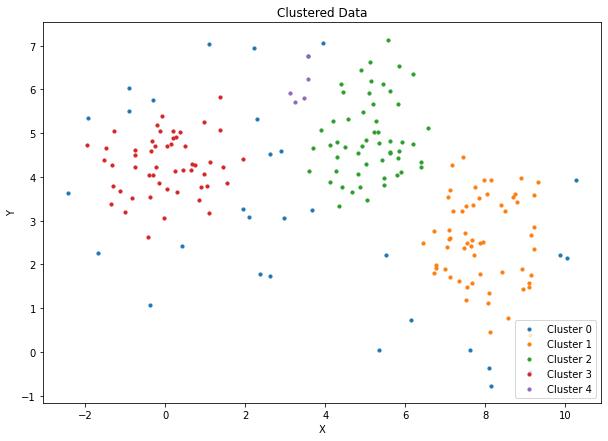

In [68]:
plt.figure(figsize=(10,7))
for clust in np.unique(cluster):
    plt.scatter(X[cluster_df["idx"][cluster_df["cluster"] == clust].values, 0], X[cluster_df["idx"][cluster_df["cluster"] == clust].values, 1], s=10, label=f"Cluster{clust}")

plt.legend([f"Cluster {clust}" for clust in np.unique(cluster)], loc ="lower right")
plt.title('Clustered Data')
plt.xlabel('X')
plt.ylabel('Y')

## Referencias

- Ayuda algoritmo KMeans: https://datascience.stackexchange.com/questions/48693/perform-k-means-clustering-over-multiple-columns

- https://towardsdatascience.com/create-your-own-k-means-clustering-algorithm-in-python-d7d4c9077670


- Ayuda algoritmo DBSCAN: https://github.com/Moosa-Ali/DBscan-Clustering-Implementation/blob/main/DBSCAN%20implementation.ipynb
